In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import os
from tqdm import *
import sklearn
from scipy.ndimage import imread
import random
from sklearn.metrics import *
import itertools
import scipy
from numpy import newaxis

plt.ion()
plt.show()

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K

doMnist = False

In [2]:
def load_lfw():
    df= pd.DataFrame()

    fullPaths = []
    baseDataFolder = 'datasets/lfw/'
    fullNames = 'lfw-names.txt'
    
    if ( os.path.isfile(baseDataFolder + 'lfw.df.csv')):
        df = pd.read_csv(baseDataFolder + 'lfw.df.csv')
    else:
        dataFolder = baseDataFolder + 'lfw_funneled/'
        dirList = os.listdir(dataFolder) # current directory
        for personName in dirList:
            if os.path.isdir(dataFolder+personName) == True:
                personFolder = os.listdir(dataFolder + personName)
                for img in personFolder:
                    if os.path.isfile(dataFolder + personName+'/'+img):
                        fullPaths.append(dataFolder+personName+'/'+ img)
                        df = df.append([(personName, dataFolder+personName+'/'+ img, img[:-4])])

        df.columns = ['person', 'imgpath', 'img']
        df.head()
        df=df.reset_index()

        df['superpixels'] = ''
        dataFolder = baseDataFolder + 'parts_lfw_funneled_superpixels_mat/'

        for i, row in df.iterrows():
            if os.path.isfile(dataFolder+row.person + '/'+row.img + '.dat'):
                df.loc[i,'superpixels'] = dataFolder+row.person + '/'+row.img + '.dat'

        df['spsegfeatures'] = ''
        dataFolder = baseDataFolder + 'parts_lfw_funneled_spseg_features/'

        for i, row in df.iterrows():
            if os.path.isfile(dataFolder+row.person + '/'+row.img + '.dat'):
                df.loc[i,'spsegfeatures'] = dataFolder+row.person + '/'+row.img + '.dat'

        df['gt'] = ''
        dataFolder = baseDataFolder + 'parts_lfw_funneled_gt/'

        for i, row in df.iterrows():
            if os.path.isfile(dataFolder+row.person + '/'+row.img + '.dat'):
                df.loc[i,'gt'] = dataFolder+row.person + '/'+row.img + '.dat'

        df['gtimages'] = ''
        dataFolder = baseDataFolder + 'parts_lfw_funneled_gt_images/'

        for i, row in df.iterrows():
            if os.path.isfile(dataFolder+row.person + '/'+row.img + '.dat'):
                df.loc[i,'gtimages'] = dataFolder+row.person + '/'+row.img + '.dat'
        
        df.to_csv(baseDataFolder + 'lfw.df.csv')
    
    if ( os.path.isfile(baseDataFolder + 'lfw.npy')):
        X_train = np.load(baseDataFolder + 'lfw.npy')
    else:
        X_train = np.stack([imread(i)/255 for i in df.imgpath.values])
        np.save(baseDataFolder + 'lfw.npy',X_train)
    
    return X_train, df

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])[:,:,newaxis]

In [41]:
import cv2
# load dataset
if doMnist == True:
    imgsize = 28
    imgchannels = 1

    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    
    print(X_train.shape)
else:
    imgsize = 250 # 250 (5*5*5*2)
    imgchannels = 3
    X_train, lfwDF = load_lfw()
    
    imgsize = 128
    X2 = np.zeros([X_train.shape[0],imgsize,imgsize,imgchannels])

    for i in range(len(X_train[0])):
        if imgchannels == 1:
            X2[i] = (rgb2gray(scipy.misc.imresize(X_train[i]*255, imgsize/250.0, interp='cubic'))/255)
        else:
            X2[i] = (scipy.misc.imresize(X_train[i]*255, imgsize/250.0, interp='cubic'))/255
        
    
    imgsize = 128 # 250 (5*5*5*2)
    X_train = X2
    del(X2)



In [39]:
%matplotlib inline

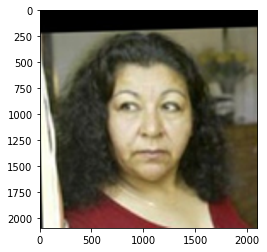

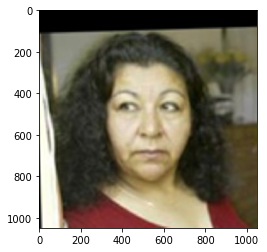

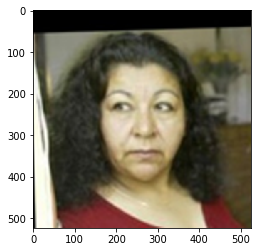

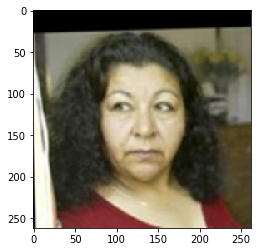

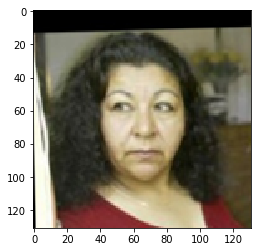

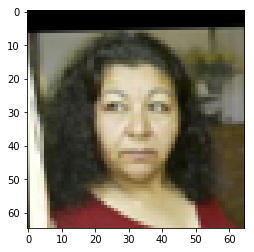

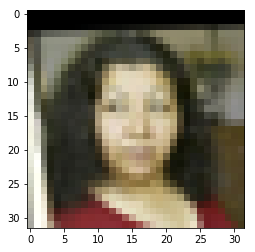

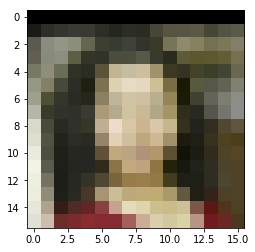

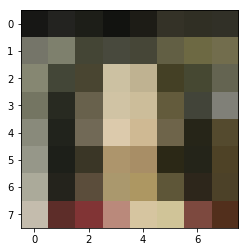

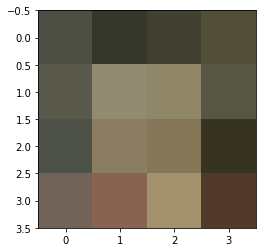

In [44]:
idx = idx+1
for i in range(12,2,-1):
    plt.figure()
    plt.imshow(scipy.misc.imresize(X_train[idx]*255, (2**i)/250, interp='cubic'))
    plt.show()

In [4]:
X_train.shape

(13233, 128, 128, 3)

In [27]:
def batchNormAndReLU(x, alpha=0.2, bnMomentum=0.8):
    x = BatchNormalization(momentum=bnMomentum)(x)
    x = LeakyReLU(alpha=alpha)(x)
    return x

def residualConv2D(x, nb_channels_in, nb_channels_out, stride=(3,3), project_shortcut=False):
    shortcut = x
        
    x = Conv2D(nb_channels_in, (1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(nb_channels_in, stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(nb_channels_out, (1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    if project_shortcut == True:
        shortcut=Conv2D(nb_channels_out, (1,1), padding='same')(shortcut)
    
    x = keras.layers.add([x,shortcut])
    
    return x
    

In [6]:
def working_generator():

    noise_shape = (100,)

    noise = Input(shape=noise_shape)
    x = Dense(256, input_shape=noise_shape)(noise)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(np.prod(img_shape), activation='tanh')(x)
    x = Reshape(img_shape)(x) # defined outside

    img = x

    return Model(noise, img)

def build_generator2():

    noise_shape = (100,)

    noise = Input(shape=noise_shape)
    x = Dense(256, input_shape=noise_shape)(noise)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Reshape([32,32,1])(x)
#     x = Conv2D(256, (3,3), padding='same', kernel_initializer='truncated_normal')(x)
#     x = LeakyReLU(alpha=0.2)(x)
#     x = Conv2D(256, (4,4), padding='same', kernel_initializer='truncated_normal')(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2D(128, (5,5), padding='same', kernel_initializer='truncated_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
#     x = Conv2D(128, (6,6), padding='same', kernel_initializer='truncated_normal')(x)
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D(size=(2,2))(x)
#     x = Conv2D(64, (7,7), padding='same', kernel_initializer='truncated_normal')(x)
#     x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(32, (7,7), padding='same', kernel_initializer='truncated_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(64, (7,7), padding='same', kernel_initializer='truncated_normal', activation='tanh')(x)

    if imgchannels != 1:
        x = Conv2D(imgchannels, (1,1), padding='same', kernel_initializer='truncated_normal', activation='tanh')(x)
        
#     print(img_shape)
#     x = Reshape(img_shape)(x) # defined outside

    img = x

    return Model(noise, img)

def build_generator_mada():

    noise_shape = (100,)
    noise = Input(shape=noise_shape)
    depth = 64 *4
    dim = 10

    x = Dense(256, activation='relu', input_shape=noise_shape)(noise)
    x = BatchNormalization(momentum=0.9)(x)
#     x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((16, 16, 1))(x)
    x = Conv2D(64,(2, 2), padding='same')(x)
    x = Dropout(0.4)(x)
    
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(int(depth/2), 5, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(int(depth/4), 5, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(int(depth/8), 5, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    
    
    x = Conv2DTranspose(int(depth/8), 5, padding='same')(x)

    
    if imgchannels != 1:
        x = Conv2D(imgchannels, (1,1), padding='same', kernel_initializer='truncated_normal', activation='tanh')(x)

    model = Model(noise, x)


#     model.compile(optimizer=RMSprop(lr=0.0002, decay=6e-8), loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer=Adam(0.0001, 0.3), loss='categorical_crossentropy', metrics=['accuracy'])
#     model.summary()
    return Model(noise, x)

def working_generator2():

    noise_shape = (100,)

    noise = Input(shape=noise_shape)
    x = Dense(256, input_shape=noise_shape)(noise)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(8192)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(np.prod(img_shape), activation='tanh')(x)
    x = Reshape(img_shape)(x) # defined outside

    img = x

    return Model(noise, img)

def build_generator():
    return build_generator_mada()

In [28]:
def working_discriminator():
    
    inputShape = (imgsize, imgsize, imgchannels)
    inp = Input(shape=inputShape)
    x = inp
    x = Flatten(input_shape=img_shape)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    validity = x

    return Model(inp, validity)    

def discriminator2():
    inputShape = (imgsize, imgsize, imgchannels)
    inp = Input(shape=inputShape)
    
    x = inp
    x = residualConv2D(x, 16, 32, (3,3), True)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(2,2)(x)
    
    x = residualConv2D(x, 32, 64, (3,3), True)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(2,2)(x)
    
    x = residualConv2D(x, 64, 128, (3,3), True)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(2,2)(x)
    
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)
    
    return Model(inp, x)


def build_discriminator():
    return discriminator2()
    return working_discriminator()
    inputShape = (imgsize, imgsize, imgchannels)

    inp = Input(shape=inputShape)
    x = inp

    x = Conv2D(64,(3,3), padding='same')(x)
    x = MaxPooling2D(2,2)(x)
    x = batchNormAndReLU(x)
    x = Conv2D(128,(3,3), padding='same')(x)
    x = MaxPooling2D(2,2)(x)
    x = batchNormAndReLU(x)
    
#     x = Conv2D(128, (1,1), padding='same')(x)
#     x = residualConv2D(x, 128, 128, (3,3), False)
#     x = MaxPooling2D(2,2)(x)
    
#     x = residualConv2D(x, 256, 256, (3,3), True)
#     x = MaxPooling2D(5,5)(x)

#     x = residualConv2D(x, 512, 512, (3,3), True)
#     x = MaxPooling2D(5,5)(x)

    x = Flatten()(x)
    x = Dense(2000)(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dense(1, activation='sigmoid')(x)

    validity = x

    return Model(inp, validity)

In [ ]:
#Testing lambda

inp = Input(shape=(2,))
inp2 = Input(shape=(2,))
x = Lambda(lambda x : x * inp2[0, 1])(inp)
mod = Model([inp, inp2], x)
mod.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
mod.summary()
mod.predict([np.array([[1, 2],[3,4]]), np.array([[7, 9],[99999999,88888]])])

In [166]:
def createMultiGenerators():
    nb_layers = 4 
    noise_shape = (256,)
    noise = Input(shape=noise_shape)
    
    layerActivation = Input(shape=(nb_layers,))
    
    layerDepths = [512, 256, 128, 64, 32, 64, 32]
    
#     x = Dense(256, activation='relu', input_shape=noise_shape)(noise)
#     x = BatchNormalization(momentum=0.9)(x)
    
    
#     x = Reshape((4,4,64))(noise)

#     x = Conv2D(512, (3,3), activation='relu', padding='same')(x)
#     out4RGB = Conv2D(3,(1,1))(x)
#     out4 = out4RGB
    
#     x = UpSampling2D((2,2))(x)
#     x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
#     out8RGB = Conv2D(3,(1,1))(x)
#     out8 = keras.layers.add([(1-layerActivation[0])*out8RGB, layerActivation[0]*UpSampling2D((2,2))(out4)])

#     x = UpSampling2D((2,2))(x)
#     x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
#     out16RGB = Conv2D(3,(1,1))(x)
#     out16 = keras.layers.add([(1-layerActivation[1])*out16RGB, layerActivation[1]*UpSampling2D((2,2))(out8)])

    
    print(layerActivation.shape)

    test = None
    lastOutput = Reshape((4,4,16))(noise)
    for l in range(nb_layers):
        print('current Layer' + str(l))
        print(lastOutput.shape)
        x = Conv2D(layerDepths[l], (3,3), activation='relu', padding='same')(lastOutput)
        
        currentOutputRGB = Conv2D(3,(1,1))(x)
        if l == 0:
            currentOutput = currentOutputRGB
            model4 = Model([noise, layerActivation], currentOutputRGB)
        else:
            tmp1 = Lambda(lambda x: x * (1-layerActivation[0,l]))(currentOutputRGB)
            tmp2 = Lambda(lambda x: x *layerActivation[0,l])(lastOutput)

            currentOutput = keras.layers.Add()([tmp1, tmp2])

        lastOutput = UpSampling2D((2,2))(currentOutput)
    
    
    
    return Model([noise,layerActivation], lastOutput)


In [188]:
def createMultiDiscriminatorsPC():
    nb_layers = 4 
    layerActivation = Input(shape=(nb_layers+1,))
    
    layerDepths = [512, 256, 128, 64, 64, 64, 32]

    models = []
    inputs = []
    lastLayer = None
    img_size = 2**(2 + nb_layers)
    inp = Input(shape=(img_size, img_size, 3))

    lastInput = inp
    lastOutput = None
    
    
    for l in range(nb_layers, 0, -1):
        print(l)
        if lastLayer == None:
            fromRGB = Conv2D(layerDepths[l],(1,1), padding='same')(lastInput)
        else:
            fromRGB = lastLayer
        
        x = Conv2D(layerDepths[l],(3,3), padding='same')(fromRGB)
        lastOutput = MaxPooling2D(2,2)(x)
        print(lastOutput.shape)
        
        lastInput = MaxPooling2D(2,2)(lastInput)
        fromRGB = Conv2D(layerDepths[l],(1,1), padding='same')(lastInput)
        
        tmp1 = Lambda(lambda x: x * (1-layerActivation[0,l]))(lastOutput)
        tmp2 = Lambda(lambda x: x *layerActivation[0,l])(fromRGB)
        lastLayer = keras.layers.Add()([tmp1, tmp2])
        
        
    output = Flatten(input_shape=img_shape)(lastLayer)
    output = Dense(1, activation='sigmoid')(output)
    
    return Model([inp, layerActivation], output)

mod = createMultiDiscriminatorsPC()
mod.summary()

4
(?, 32, 32, 64)
3
(?, 16, 16, 64)
2
(?, 8, 8, 128)
1
(?, 4, 4, 256)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_176 (InputLayer)           (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
conv2d_458 (Conv2D)              (None, 64, 64, 64)    256         input_176[0][0]                  
____________________________________________________________________________________________________
conv2d_459 (Conv2D)              (None, 64, 64, 64)    36928       conv2d_458[0][0]                 
____________________________________________________________________________________________________
max_pooling2d_61 (MaxPooling2D)  (None, 32, 32, 3)     0           input_176[0][0]                  
_____________________

In [179]:
def createMultiDiscriminators():
    nb_layers = 4 
    layerActivation = Input(shape=(nb_layers,))
    
    layerDepths = [512, 256, 128, 64, 32, 64, 32]

    models = []
    inputs = []
    lastLayer = None
    for l in range(nb_layers, 0, -1):
        img_size = 2**(2 + l)
        inp = Input(shape=(img_size, img_size, 3))
        inputs.append(inp)
        
        x = Conv2D(layerDepths[l],(1,1))(inp)
        x = Conv2D(layerDepths[l],(3,3))(x)
        x = MaxPooling2D(2,2)(x)
        
        if l == nb_layers:
            lastLayer = x
            continue
        
        img = MaxPooling2D(2,2)(lastLayer)
        img = Conv2D(layerDepths[l],(1,1))(img)
        
        tmp1 = Lambda(lambda x: x * (1-layerActivation[0,l]))(img)
        tmp2 = Lambda(lambda x: x *layerActivation[0,l])(x)
        lastLayer = keras.layers.Add()([tmp1, tmp2])
        
        
    output = Flatten(input_shape=img_shape)(lastLayer)
    output = Dense(1, activation='sigmoid')(output)
    
    print(inputs)
    for i in range(nb_layers, 0, -1):
        print(i)
        models.append(Model([inputs[i], layerActivation], output))
        
    return models

mod = createMultiDiscriminators()
mod[0].summary()

[<tf.Tensor 'input_152:0' shape=(?, 64, 64, 3) dtype=float32>, <tf.Tensor 'input_153:0' shape=(?, 32, 32, 3) dtype=float32>, <tf.Tensor 'input_154:0' shape=(?, 16, 16, 3) dtype=float32>, <tf.Tensor 'input_155:0' shape=(?, 8, 8, 3) dtype=float32>]
4


RuntimeError: Graph disconnected: cannot obtain value for tensor Tensor("input_153:0", shape=(?, 32, 32, 3), dtype=float32) at layer "input_153". The following previous layers were accessed without issue: ['input_152', 'conv2d_415']

In [171]:
def createMultiGenerators():
    nb_layers = 4 
    noise_shape = (256,)
    noise = Input(shape=noise_shape)
    
    layerActivation = Input(shape=(nb_layers,))
    
    layerDepths = [512, 256, 128, 64, 32, 64, 32]

    models = []
    
    test = None
    lastOutput = Reshape((4,4,16))(noise)
    for l in range(nb_layers):
        print('current Layer' + str(l))
        print(lastOutput.shape)
        x = Conv2D(layerDepths[l], (3,3), activation='relu', padding='same', name='outputL' + str(l))(lastOutput)
        
        if l == 0:
            currentOutputRGB = Conv2D(3,(1,1), name='curOutRGB' + str(l))(x)
            models.append( Model([noise, layerActivation], currentOutputRGB) )
        else:
            currentOutputRGB = Conv2D(3,(1,1), name='curOutRGB' + str(l))(x)
            lastOutputRGB = Conv2D(3,(1,1), name='lastOutRGB' + str(l))(lastOutput)
            tmp1 = Lambda(lambda x: x * (1-layerActivation[0,l]))(currentOutputRGB)
            tmp2 = Lambda(lambda x: x *layerActivation[0,l])(lastOutputRGB)

            currentOutput = keras.layers.Add(name='addL' + str(l))([tmp1, tmp2])
            models.append( Model([noise, layerActivation], currentOutput) )

        lastOutput = UpSampling2D((2,2), name='USOutputL'+str(l))(x)
    
    return models


In [174]:
modd = createMultiGenerators()
modd[-1].summary()


current Layer0
(?, 4, 4, 16)
current Layer1
(?, 8, 8, 512)
current Layer2
(?, 16, 16, 256)
current Layer3
(?, 32, 32, 128)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_129 (InputLayer)           (None, 256)           0                                            
____________________________________________________________________________________________________
reshape_59 (Reshape)             (None, 4, 4, 16)      0           input_129[0][0]                  
____________________________________________________________________________________________________
outputL0 (Conv2D)                (None, 4, 4, 512)     74240       reshape_59[0][0]                 
____________________________________________________________________________________________________
USOutputL0 (UpSampling2D)        (None, 8, 8, 512)     0           ou

In [140]:
a = np.array([[1,1,1,1]])
np.repeat(a, 2, axis=0)

array([[1, 1, 1, 1],
       [1, 1, 1, 1]])

In [162]:
modd = createMultiGenerators()
modd[0].summary()


modd.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

batch_size = 3
noise = np.random.normal(0, 1, (batch_size, 256))

actLayers = np.array([[0,0,1,1],[1,1,1,1],[1,0,0,0]])

modd.predict([noise, actLayers]).shape


current Layer0
(?, 4, 4, 16)
current Layer1
(?, 8, 8, 256)
current Layer2
(?, 16, 16, 256)
current Layer3
(?, 32, 32, 256)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_117 (InputLayer)       (None, 256)               0         
_________________________________________________________________
reshape_53 (Reshape)         (None, 4, 4, 16)          0         
_________________________________________________________________
convL0 (Conv2D)              (None, 4, 4, 256)         37120     
_________________________________________________________________
conv2d_364 (Conv2D)          (None, 4, 4, 3)           771       
Total params: 37,891
Trainable params: 37,891
Non-trainable params: 0
_________________________________________________________________


AttributeError: 'list' object has no attribute 'compile'

In [29]:
K.clear_session()

img_shape = (imgsize, imgsize, imgchannels)

optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

# Build and compile the generator
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

# The generator takes noise as input and generated imgs
z = Input(shape=(100,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The valid takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

discriminator.trainable = True

# print(discriminator.trainable_weights)


In [30]:
print("generator\n________")
generator.summary()
print("Discriminator\n________")
discriminator.summary()

generator
________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               25856     
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 64)        0 

In [10]:
def generate_samples(numSamples=4, subplotOffset = 0):
    noise = np.random.normal(0, 1, (numSamples, 100))
    gen_imgs = generator.predict(noise)
    
    rows = (numSamples+subplotOffset)//5+1
    cols = min((numSamples+subplotOffset),5)
    for i in range(numSamples):
        plt.subplot(rows, cols, subplotOffset+i+1)
        if ( imgchannels == 3):
            plt.imshow(gen_imgs[i])
        else:
            plt.imshow(gen_imgs[i][:,:,0], cmap='gray')
        
    return rows, cols

def plotAccuracyAndSamples(epoch, save_samples = True, save_prefix='saveFolder/'):
    plt.figure(accuracyFig.number)
    plt.clf()
    plt.plot(dLosses, label='Discriminator Loss')
    plt.plot(gLosses, label='Generator Loss')
    plt.show()
    plt.legend()
    accuracyFig.canvas.draw()

    plt.figure(sampleFig.number)
    plt.clf()
    r, c = generate_samples(20, 0)            
    sampleFig.canvas.draw()
    sampleFig.savefig(save_prefix + '{:05d}.png'.format(epoch))


In [11]:
dLosses = []
dAcc    = []
gLosses = []

In [12]:
def train(epochs, batch_size=128, update_interval=50, plot=True, save_samples = False, save_prefix='saveFolder/'):
    half_batch = int(batch_size / 2)

    weightCache = discriminator.layers[-1].get_weights()[0]
    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of new images
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        w2 = discriminator.layers[-1].get_weights()[0]
        print(abs(weightCache-w2).sum(), end= ' ', flush=True)
        weightCache = w2

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, 100))

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        valid_y = np.array([1] * batch_size)

        # Train the generator
        g_loss = combined.train_on_batch(noise, valid_y)

        # Plot the progress
#         print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        if epoch%10==0:
            print('.', end='', flush=True)
        if epoch%1000==0:
            print("\n", end='', flush=True)
        
        dLosses.append(d_loss[0])
        dAcc.append(100%d_loss[1])
        gLosses.append(g_loss)
        
        
        if (plot==True and epoch%update_interval == 0):
            plotAccuracyAndSamples(epoch, save_samples, save_prefix)

In [13]:
plt.ion()

In [14]:
%matplotlib notebook

<IPython.core.display.Javascript object>


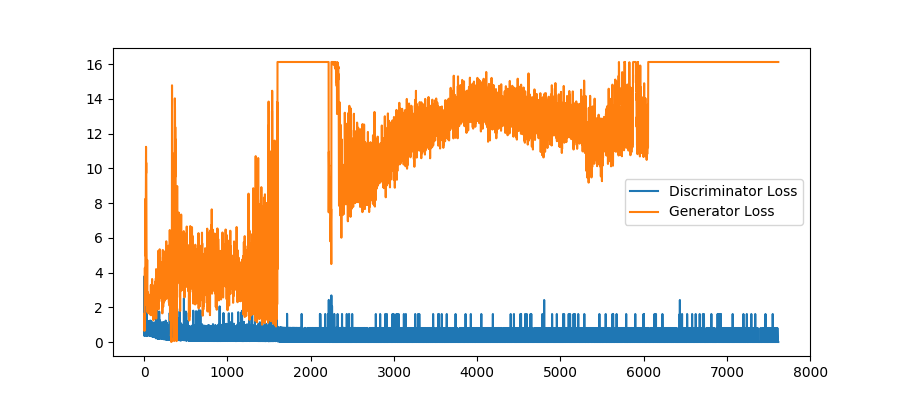

In [15]:
accuracyFig = plt.figure(figsize=(9,4))
accuracyFig.clf()

<IPython.core.display.Javascript object>


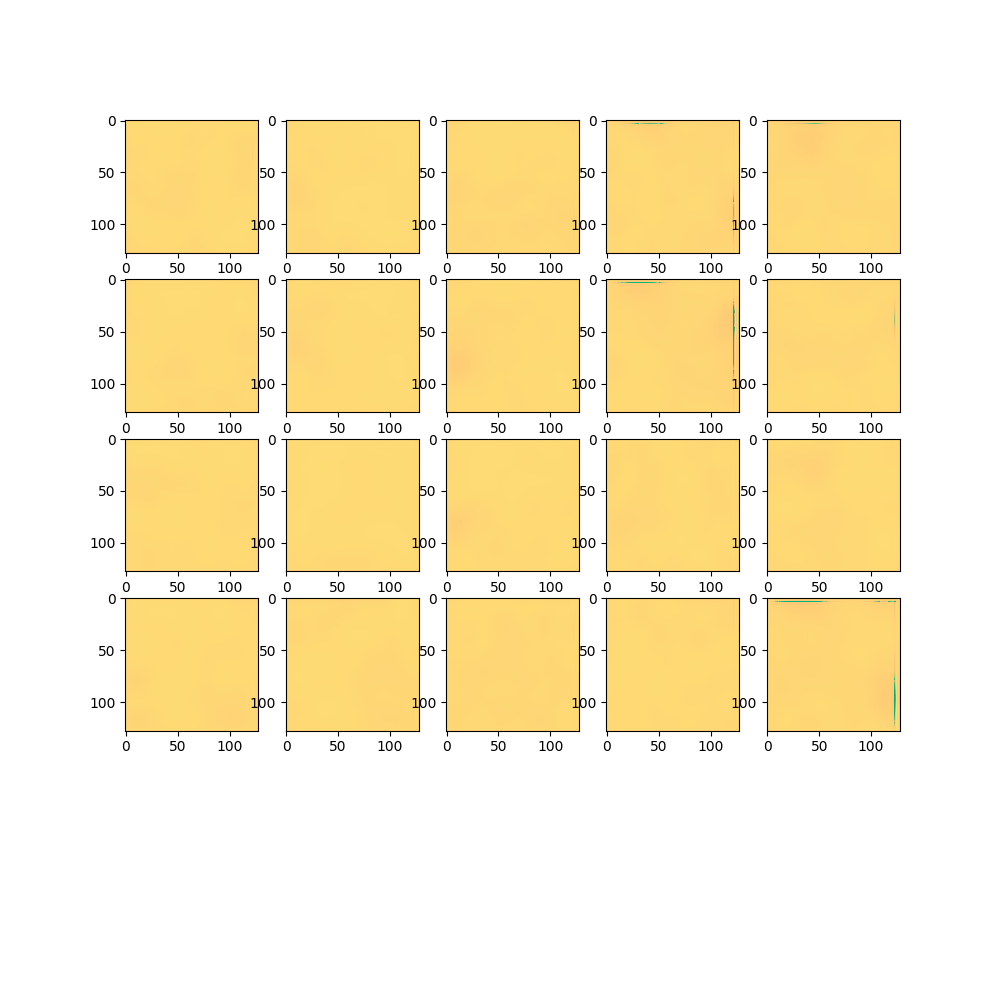

In [16]:
sampleFig = plt.figure(figsize=(10,10))
r, c = generate_samples(20, 0)
plt.subplot(r, c, 1)


In [31]:
train(epochs=50000, batch_size=20, update_interval=60, save_samples=True, save_prefix='saveFolder/mnistGAN1-')
# train(epochs=30000, batch_size=20, update_interval=1)

6.48313 .


6.0087 2.03842 0.611299 0.184487 0.0612309 0.0271268 0.0182181 0.0185294 0.0254904 0.0278771 .0.0291188 0.0238492 0.024546 0.0247764 0.0262037 0.0282644 4.03455 1.03521 0.309995 0.229745 .0.233029 0.330513 0.28387 0.221152 0.229775 0.180108 0.227804 0.193981 0.110816 3.98755 .2.7797 14.2736 12.031 3.02959 0.752497 0.217664 0.0913883 0.0577872 0.0446599 5.3292 .1.34928 0.341594 0.0865573 0.314487 0.0796326 0.0202529 0.00526861 0.00152574 0.000591941 0.000358041 .0.000303282 0.000294318 0.000294634 0.000296821 0.000299428 0.00571978 0.00163864 0.0920398 0.0233277 0.0060201 .0.00169789 0.0048495 0.0014057 0.153785 0.0388437 0.00989366 0.0755972 0.0191366 0.00493556 0.0699867 .0.0177075 0.00456291 0.00128866 0.000472775 0.000270226 0.130056 0.0328071 0.00834064 0.00220836 0.000685203 .0.000304779 0.000212335 0.000192861 0.000189307 0.000189973 0.127176 0.0320276 0.00812114 0.00213834 0.000652895 .0.00028472 0.000194147 0.000175834 0.00310849 0.00229769 0.000721242 0.000371695 0.016328 0.00

0.0142946 0.0281251 0.0120648 0.0198784 0.00884947 0.00703844 0.0114509 0.0250909 0.0718062 0.0460286 .0.0188828 0.0111117 0.0206144 0.0166287 0.0463415 0.0335986 0.0342869 0.0245229 0.0604299 0.0412881 .0.0159987 0.00930007 0.00626299 0.00604635 0.00624287 0.00677627 0.00785498 0.00693726 0.0220672 0.039314 .0.0126561 0.0192137 0.0151362 0.0424343 0.013522 0.00684191 0.0137347 0.00987005 0.0128403 0.00953208 .0.00868162 0.00534566 0.00547573 0.0104057 0.00725247 0.00908728 0.00708639 0.00699562 0.00648042 0.00659427 .0.0600648 0.0169335 0.00790372 0.0154829 0.0122176 0.00612599 0.00520736 0.0162619 0.0142222 0.0058459 .0.0124373 0.00998007 0.0211785 0.0159599 0.0121639 0.00727074 0.0140588 0.00588954 0.00512159 0.00704132 .0.0296816 0.0191681 0.00743917 0.0126914 0.00868443 0.0111804 0.0266573 0.0099558 0.0178614 0.0133145 .0.034485 0.0328646 0.0146751 0.00713891 0.00708243 0.00742716 0.00550898 0.0261829 0.0185333 0.0459674 .0.0325579 0.041044 0.0390092 0.0113719 0.00569999 0.0043599

0.0140131 0.00802361 0.00436594 0.0093392 0.00762656 0.00585193 0.00493635 0.00622663 0.00511105 0.0181617 .0.0143207 0.00755438 0.00760091 0.0172737 0.015767 0.00720203 0.00550386 0.0100749 0.006788 0.00764412 .0.0171451 0.0064443 0.00565617 0.00639924 0.00396504 0.00544971 0.00761668 0.00700792 0.0213899 0.0231665 .0.0220327 0.0194822 0.00906495 0.0438528 0.0305154 0.00936497 0.00556701 0.00972061 0.0205405 0.00779462 .0.00396554 0.00840176 0.00902099 0.0224955 0.022268 0.00694219 0.00567024 0.00396201 0.00315392 0.0117375 .0.018642 0.00996756 0.0103092 0.00804205 0.00946018 0.0197281 0.0365111 0.0134048 0.00538595 0.00726744 .0.00915314 0.00993067 0.0218582 0.0101721 0.00964728 0.0147977 0.0182297 0.0100213 0.00626904 0.00411573 .0.00351334 0.010133 0.0195717 0.00692791 0.00827612 0.00404367 0.00486851 0.00526309 0.0304113 0.0221074 .0.00924696 0.00497293 0.00505611 0.00471101 0.0037345 0.0168298 0.0121981 0.0196268 0.0120097 0.00727123 .0.00579218 0.00433409 0.00325136 0.0343406 0.

0.0287153 0.0147607 0.00515532 0.00511392 0.0180677 0.013007 0.00500872 0.00721104 .0.00851803 0.00479677 0.00330367 0.0210518 0.0160387 0.00609235 0.0284831 0.0236395 0.0123475 0.010849 .0.00607221 0.00426722 0.00888257 0.00987023 0.00782189 0.0115654 0.012446 0.0252777 0.0205216 0.00792238 .0.00534682 0.00425725 0.00330871 0.00668872 0.0106979 0.00598495 0.00965852 0.00922658 0.00513366 0.0040967 .0.0390381 0.0130109 0.00543616 0.00392336 0.00306707 0.0114746 0.019989 0.0177413 0.0103424 0.0141388 .0.00951892 0.0078229 0.045778 0.0146077 0.00968388 0.00401908 0.00345383 0.00752023 0.0053986 0.00474507 .0.0039927 0.0117727 0.0107494 0.0140628 0.00601718 0.0052092 0.00835332 0.0137122 0.0243986 0.0136088 .0.00430562 0.00273723 0.0410793 0.0112263 0.00913605 0.008978 0.00950754 0.00563753 0.0144601 0.00813093 .0.00325123 0.00233172 0.00316376 0.00259162 0.00415095 0.00588193 0.00445324 0.0109346 0.00880356 0.00485796 .0.0105245 0.0126178 0.0105291 0.0114277 0.00647046 0.00643117 0.00476

0.0134421 0.0100334 0.00554757 0.00975019 0.00768234 0.0113752 0.0222684 0.0140056 0.0141777 0.0200175 .0.0206458 0.0103001 0.00448977 0.0161487 0.0118956 0.0159064 0.0134197 0.0107748 0.007383 0.0135091 .0.013952 0.0208963 0.0408833 0.0288719 0.0118569 0.00427979 0.0195018 0.0143312 0.0220489 0.0223673 .0.0167159 0.0279304 0.0330418 0.025972 0.0137801 0.00877741 0.00657533 0.00447367 0.00310742 0.00682575 .0.0151761 0.0166972 0.00862288 0.00804397 0.00995688 0.00581495 0.0119437 0.0206854 0.0154021 0.00753829 .0.0101173 0.0108574 0.00702902 0.0149241 0.010312 0.00345297 0.00357342 0.00285392 0.00491692 0.00724773 .0.0042165 0.00742776 0.00534687 0.00240936 0.0032963 0.00663429 0.0111244 0.0174344 0.00942118 0.00387319 .0.00806683 0.0077782 0.0117807 0.00653229 0.00862571 0.00467974 0.0146606 0.0119147 0.031487 0.0238002 .0.00700289 0.0263064 0.041397 0.0213313 0.0163068 0.0111546 0.0240205 0.0224895 0.00952989 0.00687716 .0.00453217 0.0154292 0.0108806 0.00999748 0.0229852 0.0161594 0

0.0460531 0.0246415 0.00903396 .0.029881 0.0204931 0.0103184 0.00533221 0.0027949 0.00189106 0.00393131 0.00203736 0.00731532 0.00557543 .0.00362426 0.0221914 0.0393842 0.0218821 0.00598582 0.0216736 0.0161743 0.0420127 0.0348544 0.039875 .0.0579024 0.0450634 0.0316599 0.0153006 0.0292063 0.011663 0.00981744 0.00862222 0.00400335 0.00285616 .0.0197637 0.0141482 0.00935319 0.00554727 0.00260163 0.0032131 0.0319974 0.0149469 0.00863145 0.0266482 .0.02402 0.0194146 0.0133992 0.0133341 0.0167205 0.00750854 0.00943116 0.0163842 0.017133 0.0535001 .0.0361231 0.012115 0.00485921 0.00206416 0.00344612 0.012159 0.0176049 0.0189271 0.00947017 0.0188268 .0.0128437 0.00598154 0.00364808 0.00200202 0.0442251 0.011957 0.00363637 0.0284434 0.0206601 0.00958514 .0.00622215 0.00349107 0.00420798 0.00340597 0.00467975 0.016514 0.0137442 0.00517704 0.0130003 0.011544 .0.0187431 0.0119718 0.00887797 0.00679601 0.00825774 0.0123541 0.00899958 0.0104926 0.0155387 0.0186471 .0.0113818 0.0224928 0.0315654 0.0

0.0144546 0.00628398 0.00263431 0.00186104 0.00125419 0.00167785 0.00752607 0.0407074 0.0390129 0.0189958 .0.00870732 0.00319642 0.0139025 0.0100697 0.00262803 0.00563203 0.00396621 0.00199984 0.012167 0.0115717 .0.00442117 0.00221455 0.00102494 0.000737579 0.00261735 0.00929389 0.0335378 0.0257495 0.00839403 0.0125612 .0.0168083 0.00848869 0.00613399 0.00349028 0.00123157 0.00303916 0.00475221 0.00261411 0.00276409 0.00421125 .0.00616755 0.00622944 0.0195411 0.0133891 0.0154454 0.00880773 0.00332248 0.00118592 0.000679413 0.000625955 .0.00462709 0.012797 0.0310852 0.0193698 0.0204336 0.0114542 0.00520793 0.00154663 0.00134216 0.0105523 .0.00312528 0.00445928 0.0111714 0.00676534 0.0116319 0.00715669 0.0296501 0.022864 0.0063396 0.0100885 .0.00761751 0.00472189 0.00202076 0.00746182 0.0114128 0.00598301 0.00726678 0.00475803 0.00172762 0.00115591 .0.0098881 0.00837513 0.00282355 0.00402098 0.00948134 0.00583285 0.00267078 0.00388725 0.00240909 0.00171319 .0.0063755 0.00462576 0.0028596

0.00475318 0.0107049 0.00659316 0.00704404 0.00461876 .0.00482077 0.00485804 0.00483483 0.00798426 0.00708899 0.00494242 0.00225739 0.00163532 0.00267362 0.00827769 .0.006307 0.00579884 0.00592239 0.00438318 0.0376464 0.0102416 0.00481258 0.0026663 0.000806837 0.000394692 .0.00338613 0.00850474 0.00367201 0.00133702 0.00266959 0.00292165 0.000911171 0.000578569 0.000491603 0.0003515 .0.00120879 0.000947382 0.012192 0.00908186 0.0050537 0.00343095 0.0141774 0.0127579 0.00455003 0.00371511 .0.00824086 0.00737398 0.00300391 0.000866179 0.00456511 0.00594491 0.00281407 0.00344481 0.00269907 0.00108154 .0.000449917 0.000350732 0.0039578 0.00318419 0.00718602 0.0118769 0.0108077 0.00485263 0.00787157 0.00792927 .0.0043239 0.00407556 0.00330975 0.0051709 0.00330822 0.0137376 0.00997262 0.00265982 0.00531157 0.00406257 .0.00405499 0.00452113 0.0050675 0.0292943 0.0375357 0.0242353 0.00946141 0.00241401 0.00074448 0.000770811 .0.000449212 0.000378855 0.00036624 0.000364635 0.000364668 0.0003649

0.0053026 0.00162425 0.000716351 0.000492958 0.000441246 0.000430762 0.000429017 0.00324033 0.00145775 0.00441676 .0.00140074 0.00135107 0.000648646 0.000478968 0.000441009 0.00292054 0.0010385 0.000575517 0.000463829 0.000440081 .0.00043568 0.00043508 0.000435273 0.000435665 0.0011284 0.000598808 0.000471775 0.000443745 0.000734046 0.000502654 .0.00044991 0.000440601 0.000439728 0.000440024 0.000440423 0.000440854 0.000441296 0.00010862 2.53317e-05 0.00215384 .0.000538568 0.000133266 3.06855e-05 6.01232e-06 8.2539e-07 6.20934e-08 2.85166e-09 0.00144817 0.000361601 8.85151e-05 .0.000478625 0.000118295 2.68441e-05 0.0010608 0.000264452 6.40219e-05 1.35713e-05 2.28109e-06 2.49093e-07 0.000665611 .0.000165245 3.87109e-05 7.80649e-06 1.14352e-06 9.07821e-08 4.41861e-09 3.05647e-10 2.38742e-11 4.54747e-13 5.68434e-14 .0.0 0.000479795 0.000118424 2.68752e-05 5.14473e-06 6.84422e-07 4.37664e-08 0.000467962 0.000639006 0.000158755 .0.00151244 0.00400213 0.00100118 0.000249993 6.00811e-05 1.250

9.56737e-07 .7.13121e-08 3.49166e-09 2.38799e-10 6.13909e-12 0.0 0.000870568 0.000216979 5.17745e-05 1.07014e-05 1.71759e-06 .0.00434447 0.0010868 0.000271066 6.57578e-05 0.000468978 0.000985255 0.000245609 5.91408e-05 1.25128e-05 2.09633e-06 .2.31779e-07 1.09947e-08 6.14705e-10 2.12026e-11 9.66338e-13 0.0 0.0 0.0 0.0 0.0 .0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 .0.0 0.0 0.0 0.000940108 0.00023462 5.61357e-05 1.16461e-05 1.93463e-06 1.78197e-07 9.12996e-09 .4.35193e-10 1.2335e-11 1.02318e-12 0.0 0.0 0.0 0.0 0.0 0.0 0.0004821 .0.000119034 2.70118e-05 0.000486751 0.000120213 2.73207e-05 5.22144e-06 7.19792e-07 4.53027e-08 2.42221e-09 1.80023e-10 .0.000493455 0.000121973 2.76937e-05 0.000950679 0.000236977 5.69848e-05 1.18837e-05 1.91601e-06 1.99645e-07 8.87064e-09 .4.79417e-10 0.000508076 0.000125466 2.86949e-05 5.50774e-06 7.41453e-07 4.94271e-08 2.31989e-09 1.98838e-10 3.9222e-12 .5.68434e-14 0.000935283 0.000233087 5.62066e-05 1.15787e-05 1.80887e-06 1.53583e-07 7.77152e-09 3.85e-10 1

KeyboardInterrupt: 

In [ ]:
discriminator.layers

In [ ]:
weightCache = discriminator.layers[-3].get_weights()[0]
weightCache

In [ ]:
weights = [tensor for tensor in discriminator.trainable_weights if discriminator.get_layer(tensor.name[:-2]).trainable]
# optimizer = discriminator.optimizer

# optimizer.get_gradients(discriminator.total_loss, weights)
weights

In [ ]:
discriminator.layers[6].output_shape[-1]